In [1]:
import os
import numpy as np
import torch.nn as nn
import torch
import random
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
import torchvision
from d2l import torch as d2l
BASE_DIR = os.path.dirname(os.getcwd())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
datadir="/home/omnisky/shenxiaochen/"
transform_train = torchvision.transforms.Compose([
 
    torchvision.transforms.CenterCrop(96),
    #torchvision.transforms.RandomRotation(90),
    torchvision.transforms.ToTensor(),
    
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

transform_test = torchvision.transforms.Compose([
    

    torchvision.transforms.CenterCrop(96),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

train_ds= torchvision.datasets.ImageFolder(
    os.path.join(datadir, 'train1'),
    transform=transform_train) 
test_ds= torchvision.datasets.ImageFolder(
    os.path.join(datadir, 'test'),
    transform=transform_test) 

In [3]:
#batch_size=112
batch_size=128
batch_size2=256
#batch_size=56
train_iter = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [4]:
import torchvision.models as models

def get_googlenet(path_state_dict, device, vis_model=False):
    """
    
    :param path_state_dict:
    :return:
    """
    model = models.googlenet(init_weights=False)
    if path_state_dict:
        pretrained_state_dict = torch.load(path_state_dict)
        model.load_state_dict(pretrained_state_dict)
    model.eval()

    if vis_model:
        from torchsummary import summary
        summary(model, input_size=(3, 224, 224), device="cpu")

    model.to(device)
    return model

path_state_dict = os.path.join(BASE_DIR, "data", "googlenet-1378be20.pth")
googlenet_model = get_googlenet(path_state_dict, device, False)
num_classes=5
# main
num_ftrs = googlenet_model.fc.in_features
googlenet_model.fc = nn.Linear(num_ftrs, num_classes)

# aux_1
num_ftrs_1 = googlenet_model.aux1.fc2.in_features
googlenet_model.aux1.fc2 = nn.Linear(num_ftrs_1, num_classes)

# aux_2
num_ftrs_2 = googlenet_model.aux2.fc2.in_features
googlenet_model.aux2.fc2 = nn.Linear(num_ftrs_2, num_classes)
    
#googlenet_model.to(device)
print(googlenet_model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [5]:

LR=0.05
lr_decay_step=20
#flag = 0
flag = 1
if flag:
    fc_params_id = list(map(id, googlenet_model.aux1.parameters()))+list(map(id, googlenet_model.aux2.parameters()))+list(map(id, googlenet_model.fc.parameters()))  # 返回的是parameters的 内存地址
    base_params = filter(lambda p: id(p) not in fc_params_id, googlenet_model.parameters())
    optimizer = optim.SGD([
        {'params': base_params, 'lr': LR * 0.1},  # 0
        {'params': googlenet_model.aux1.parameters(), 'lr': LR},
        {'params': googlenet_model.aux2.parameters(), 'lr': LR},
        {'params': googlenet_model.fc.parameters(), 'lr': LR}], momentum=0.9)

else:
    optimizer = optim.SGD(googlenet_model.parameters(), lr=LR, momentum=0.9) 

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1)  

print(optimizer)
print(scheduler)

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.005000000000000001
    lr: 0.005000000000000001
    momentum: 0.9
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    initial_lr: 0.05
    lr: 0.05
    momentum: 0.9
    nesterov: False
    weight_decay: 0

Parameter Group 2
    dampening: 0
    initial_lr: 0.05
    lr: 0.05
    momentum: 0.9
    nesterov: False
    weight_decay: 0

Parameter Group 3
    dampening: 0
    initial_lr: 0.05
    lr: 0.05
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [7]:
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    
    if isinstance(net, torch.nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device
    
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            
            X = [x.to(device) for x in X]
        else:
            X = X.to(device,non_blocking=True)
        y = y.to(device,non_blocking=True)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [8]:
def train_ch6(net, train_iter, test_iter, num_epochs, device):
    
    
    print('training on', device)
    net.to(device)
    LR=0.01
    lr_decay_step=20
    #flag = 0
    flag = 1
    if flag:
        fc_params_id = list(map(id, googlenet_model.aux1.parameters()))+list(map(id, googlenet_model.aux2.parameters()))+list(map(id, googlenet_model.fc.parameters()))  # 返回的是parameters的 内存地址
        base_params = filter(lambda p: id(p) not in fc_params_id, googlenet_model.parameters())
        optimizer = optim.SGD([
            {'params': base_params, 'lr': LR * 0.1},  # 0
            {'params': googlenet_model.aux1.parameters(), 'lr': LR},
            {'params': googlenet_model.aux2.parameters(), 'lr': LR},
            {'params': googlenet_model.fc.parameters(), 'lr': LR}], momentum=0.9)

    else:
        optimizer = optim.SGD(googlenet_model.parameters(), lr=LR, momentum=0.9)  

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=0.1) 
   
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        
        metric = d2l.Accumulator(3)  
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss_main, aug_loss1, aug_loss2 = loss(y_hat[0], y), loss(y_hat[1], y),loss(y_hat[2], y)
                                          
            l = loss_main + (0.3 * aug_loss1) + (0.3 * aug_loss2)
            #l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat[0].data, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        scheduler.step()
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        torch.save(net.state_dict(), './network_%s_params.pth'%(epoch))
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.009, train acc 1.000, valid acc 0.985
2713.0 examples/sec on cuda:0


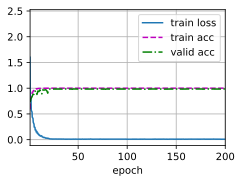

In [9]:
train_ch6(net=googlenet_model,train_iter=train_iter,test_iter=test_iter, num_epochs=200, device=d2l.try_gpu())

In [10]:
# 2022.1.19 googlenet_finetune shen xiao chen 

In [11]:
outsidetest_ds= torchvision.datasets.ImageFolder(
    os.path.join(datadir, 'outside_test'),
    transform=transform_test) 
outsidetest_iter = torch.utils.data.DataLoader(outsidetest_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [18]:
googlenet_model.load_state_dict(torch.load('./network_params.pth'))

<All keys matched successfully>

In [19]:
evaluate_accuracy_gpu(googlenet_model,test_iter)

0.9673954737245877

In [20]:
evaluate_accuracy_gpu(googlenet_model,outsidetest_iter)

0.8290120087336245